In [32]:
import pickle
import time
import numpy as np
import operator
import argparse
import copy
import os
import math
import glob
from collections import Counter, defaultdict
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix,\
        ConfusionMatrixDisplay

%matplotlib inline

In [54]:
ROOT_DIR = '/home/blansdell/projects/comet/FAIRY/'
TOPK = 5

#1024 patches
result_path = f"{ROOT_DIR}/QUERY_RESULTS/all/results_1024.pkl"
#1024 patches, pathologist annotation
#result_path = f"{ROOT_DIR}/QUERY_RESULTS/all/results.pkl"

In [55]:
result_path

'/home/blansdell/projects/comet/FAIRY//QUERY_RESULTS/all/results_1024.pkl'

In [56]:
class Args(object):
    def __init__(self):

        self.result_path = result_path
        self.csv_path = f"{ROOT_DIR}/QUERY_RESULTS/all/summary.csv"
        self.site = 'all'
        
args = Args()

In [57]:
def Uncertainty_Cal(bag, is_organ=False):
    """
    Implementation of Weighted-Uncertainty-Cal in the paper.
    Input:
        bag (list): A list of dictionary which contain the searhc results for each mosaic
    Output:
        ent (float): The entropy of the mosaic retrieval results
        label_count (dict): The diagnois and the corresponding weight for each mosaic
        hamming_dist (list): A list of hamming distance between the input mosaic and the result
    """
    if len(bag) >= 1:
        label = []
        hamming_dist = []
        label_count = defaultdict(float)
        for bres in bag:
            if is_organ:
                label.append(bres['site'])
            else:
                label.append(bres['diagnosis'])
            hamming_dist.append(bres['hamming_dist'])

        # Counting the diagnoiss by weigted count
        # If the count is less than 1, round to 1
        for lb_idx, lb in enumerate(label):
            label_count[lb] += (1. / (lb_idx + 1)) * weight[lb]
        for k, v in label_count.items():
            if v < 1.0:
                v = 1.0
            else:
                label_count[k] = v

        # Normalizing the count to [0,1] for entropy calculation
        total = 0
        ent = 0
        for v in label_count.values():
            total += v
        for k in label_count.keys():
            label_count[k] = label_count[k] / total
        for v in label_count.values():
            ent += (-v * np.log2(v))
        return ent, label_count, hamming_dist
    else:
        return None, None, None


def Clean(len_info, bag_summary):
    """
    Implementation of Clean in the paper
    Input:
        len_info (list): The length of retrieval results for each mosaic
        bag_summary (list): A list that contains the positional index of mosaic,
        entropy, the hamming distance list, and the length of retrieval results
    Output:
        bag_summary (list): The same format as input one but without low quality result
        (i.e, result with large hamming distance)
        top5_hamming_distance (float): The mean of average hamming distance in top 5
        retrival results of all mosaics
    """
    LOW_FREQ_THRSH = 3
    LOW_PRECENT_THRSH = 5
    HIGH_PERCENT_THRSH = 95
    len_info = [b[-1] for b in bag_summary]
    if len(set(len_info)) <= LOW_FREQ_THRSH:
        pass
    else:
        bag_summary = [b for b in bag_summary if b[-1]
                       > np.percentile(len_info, LOW_PRECENT_THRSH)
                       and b[-1] < np.percentile(len_info, HIGH_PERCENT_THRSH)]

    # Remove the mosaic if its top5 mean hammign distance is bigger than average
    top5_hamming_dist = np.mean([np.mean(b[2][0:TOPK]) for b in bag_summary])

    bag_summary = sorted(bag_summary, key=lambda x: (x[1]))  # sort by certainty
    bag_summary = [b for b in bag_summary if np.mean(b[2][0:TOPK]) <= top5_hamming_dist]
    return bag_summary, top5_hamming_dist


def Filtered_BY_Prediction(bag_summary, label_count_summary):
    """
    Implementation of Filtered_By_Prediction in the paper
    Input:
        bag_summary (list): The same as the output from Clean
        label_count_summary (dict): The dictionary storing the diagnosis occurrence 
        of the retrieval result in each mosaic
    Output:
        bag_removed: The index (positional) of moaic that should not be considered 
        among the top5
    """
    voting_board = defaultdict(float)
    for b in bag_summary[0:TOPK]:
        bag_index = b[0]
        for k, v in label_count_summary[bag_index].items():
            voting_board[k] += v
    final_vote_candidates = sorted(voting_board.items(), key=lambda x: -x[1])
    fv_pointer = 0
    while True:
        final_vote = final_vote_candidates[fv_pointer][0]
        bag_removed = {}
        for b in bag_summary[0:TOPK]:
            bag_index = b[0]
            max_vote = max(label_count_summary[bag_index].items(), key=operator.itemgetter(1))[0]
            if max_vote != final_vote:
                bag_removed[bag_index] = 1
        if len(bag_removed) != len(bag_summary[0:TOPK]):
            break
        else:
            fv_pointer += 1
    return bag_removed

In [58]:
# Load the result file and corresponding slide's diagnosis label
with open(args.result_path, 'rb') as handle:
    results = pickle.load(handle)

# Count the number of slide in each diagnosis (organ)
if args.site == 'organ':
    topK_mMV = 10
    type_of_diagnosis = [os.path.basename(e) for e in glob.glob(f"{ROOT_DIR}/DATA/LATENT/*")]
else:
    topK_mMV = TOPK
    type_of_diagnosis = [os.path.basename(e) for e in glob.glob(f"{ROOT_DIR}/DATA/LATENT/{args.site}/*")]
total_slide = {k: 0 for k in type_of_diagnosis}
for k, v in results.items():
    total_slide[v['label_query']] += 1

# Using the inverse count as a weight for each diagnosis
sum_inv = 0
for v in total_slide.values():
    if v:
        sum_inv += (1./v)

# Set a parameter k  to make the weight sum to k (k = 10, here)
if args.site == 'organ':
    norm_fact = 30 / sum_inv
else:
    norm_fact = 10 / sum_inv

weight = {}
for k,v in total_slide.items():
    if v:
        weight[k] = norm_fact * 1./v
    else:
        weight[k] = norm_fact

#weight = {k: norm_fact * 1./v for k, v in total_slide.items()}

metric_dict = {k: {'accuracy': 0, 'precision': 0, 'total_slide': 0}
               for k in weight.keys()}
bag_for_ret = {k: {} for k in weight.keys()}
t_start = time.time()

summary_df = pd.DataFrame()

In [59]:
# Evaluating the result diagnosis by diagnosis
all_results = {}
for evlb in weight.keys():
    eval_label = evlb
    #print(evlb)
    corr = 0
    percision = 0
    avg_percision = 0
    count = 0
    for test_slide in results.keys():
        test_slide_result = results[test_slide]['results']
        label_query = results[test_slide]['label_query']
        if label_query != eval_label:
            continue
        else:
            # Filter out complete failure case (i.e.,
            # All mosaics fail to retrieve a patch that meet the criteria)
            ttlen = 0
            for tt in test_slide_result:
                ttlen += len(tt)
            if ttlen == 0:
                count += 1
                continue
            bag_result = []
            bag_summary = []
            len_info = []
            label_count_summary = {}
#             try:
            for idx, bag in enumerate(test_slide_result):
                if args.site == 'organ':
                    ent, label_cnt, dist = Uncertainty_Cal(bag, is_organ=True)
                else:
                    ent, label_cnt, dist = Uncertainty_Cal(bag)
                if ent is not None:
                    label_count_summary[idx] = label_cnt
                    bag_summary.append((idx, ent, dist, len(bag)))
                    len_info.append(len(bag))
#             except KeyError as e:
#                 print(e)
#                 continue
        
        bag_summary_dirty = copy.deepcopy(bag_summary)
        ##The bag_summary here is sorted by certainty
        #This means that we pick slides below based only on the query mosiac
        #that has highest certainty. Perhaps basing it on one mosiac isn't a good idea?
        #What if only that single mosiac has very high similarity, and the rest is totally different?
        bag_summary, hamming_thrsh = Clean(len_info, bag_summary)
        bag_removed = Filtered_BY_Prediction(bag_summary, label_count_summary)

        # Process to calculate the final ret slide
        ret_final = []
        visited = {}

        for b in bag_summary:
            bag_index = b[0]
            uncertainty = b[1]
            res = results[test_slide]['results'][bag_index]
            for r in res:
                if uncertainty == 0:
                    if r['slide_name'] not in visited:
                        if args.site == 'organ':
                            ret_final.append((r['slide_name'], r['hamming_dist'],
                                              r['site'], uncertainty,
                                              bag_index, r['query_slide'], r['query_coords'], (r['x'], r['y'])))
                        else:
                            ret_final.append((r['slide_name'], r['hamming_dist'],
                                              r['diagnosis'], uncertainty,
                                              bag_index, r['query_slide'], r['query_coords'], (r['x'], r['y'])))
                        visited[r['slide_name']] = 1
                else:
                    if (r['hamming_dist'] <= hamming_thrsh) and\
                       (r['slide_name'] not in visited):
                        if args.site == 'organ':
                            ret_final.append((r['slide_name'], r['hamming_dist'],
                                              r['site'], uncertainty,
                                              bag_index, r['query_slide'], r['query_coords'], (r['x'], r['y'])))
                        else:
                            ret_final.append((r['slide_name'], r['hamming_dist'],
                                              r['diagnosis'], uncertainty,
                                              bag_index, r['query_slide'], r['query_coords'], (r['x'], r['y'])))
                        visited[r['slide_name']] = 1

        #print(ret_final)
        ret_final_tmp = [e for e in
                         sorted(ret_final, key=lambda x: (x[3], x[1]))
                         if e[-4] not in bag_removed][0:topK_mMV]

        ret_final_ = [e[0] for e in
                     sorted(ret_final, key=lambda x: (x[3], x[1]))
                     if e[-4] not in bag_removed][0:topK_mMV]

        ret_final = [e[2] for e in
                     sorted(ret_final, key=lambda x: (x[3], x[1]))
                     if e[-4] not in bag_removed][0:topK_mMV]

        all_results[test_slide] = ret_final_tmp

In [60]:
diag_dict = {'Spindle': 'RMS_S', 'ARMS': 'RMS_A', 'ERMS': 'RMS_E'}

#metadata_fn = '/home/blansdel/projects/comet/comet_rms/raw/RMS_samples_083121.csv'
metadata_fn = '/home/blansdell/projects/comet/comet_rms/raw/RMS_samples_083121.csv'

metadata = pd.read_csv(metadata_fn, header = 2).iloc[:,:21]
metadata = metadata[pd.notnull(metadata['Slide Scan File'])][['Slide Scan File', 'Site', 'Subtype (Corrected)']]
metadata = metadata.rename(columns = {'Slide Scan File': 'query', 'Site': 'site', 'Subtype (Corrected)': 'query_class'})
metadata['query'] = metadata['query'].apply(lambda x: str(int(x))+'_')
metadata['query_class'] = metadata['query_class'].apply(lambda x: diag_dict[x] if x in diag_dict else pd.NA)
metadata['site'] = metadata['site'].apply(lambda x: str(x).lower().split(' ')[0])
metadata = metadata[pd.notnull(metadata['query_class'])]
metadata

,query,site,query_class
0,6799_,face,RMS_S
1,6798_,dura,RMS_S
2,8081_,omental,RMS_A
3,8083_,chest,RMS_A
4,6803_,face,RMS_S
...,...,...,...
283,5702_,retroperitoneum,RMS_E
284,6836_,paranasal,RMS_A
285,6844_,lymph,RMS_E
286,6848_,lung,RMS_E


In [61]:
results = pd.DataFrame({'query':[], 'hit_slide':[], 'query_class':[], 'hit_class':[]})
for slide,vals in all_results.items():
    for (hit_id, hamming, typ, uncertainty, index, _, _, _) in vals:
        qc = metadata.loc[metadata['query'] == slide, 'query_class'].values
        if not len(qc): continue
        row = {'query': [slide], 'hit_slide': [hit_id], 'query_class': [qc], 'hit_class': [typ]}
        results = pd.concat([results, pd.DataFrame(row)])
results

,query,hit_slide,query_class,hit_class
0,6216_,6796_,[RMS_E],RMS_E
0,6216_,6806_,[RMS_E],RMS_E
0,6216_,6172_,[RMS_E],RMS_E
0,6216_,8133_,[RMS_E],RMS_A
0,6216_,6193_,[RMS_E],RMS_E
...,...,...,...,...
0,6250_,6205_,[RMS_A],RMS_A
0,6250_,6951_,[RMS_A],RMS_A
0,6250_,6808_,[RMS_A],RMS_E
0,6250_,6211_,[RMS_A],RMS_E


In [62]:
#Take the majority vote, if there are two the 
results_summary = results.groupby('query')['hit_class'].agg(pd.Series.mode).reset_index()
results_summary = pd.merge(results_summary, metadata, on = 'query', how = 'left')
results_summary.loc[pd.isnull(results_summary['query_class']), 'query_class'] = 'RMS'
results_summary = results_summary.rename(columns = {'hit_class': 'prediction', 'query_class':'label'})
results_summary    

,query,prediction,site,label
0,6161_,RMS_E,chest,RMS_S
1,6164_,RMS_A,chest,RMS_E
2,6170_,RMS_E,hand,RMS_A
3,6172_,RMS_E,nasopharyngeal,RMS_E
4,6175_,RMS_E,orbit,RMS_E
...,...,...,...,...
98,8134_,RMS_A,abdomen,RMS_E
99,8135_,RMS_E,lung,RMS_A
100,8135_,RMS_E,lung,RMS_A
101,8136_,RMS_E,nasopharyngeal,RMS_E


In [63]:
#Generous tie breaking
count = 0
gen_count = 0
for idx in range(len(results_summary)):
    pred = results_summary.iloc[idx,1]
    lab = results_summary.iloc[idx,2]
    if type(pred) is np.ndarray:
        count += 1
        if lab in pred:
            results_summary.iloc[idx,1] = lab
            gen_count += 1
        else:
            results_summary.iloc[idx,1] = pred[np.random.randint(0, 1)]

In [64]:
print("Number of ties", count)
print("Number of generous tie breaks", gen_count)

Number of ties 2
Number of generous tie breaks 0


In [65]:
confusion_matrix(results_summary['label'], results_summary['prediction'])

array([[27, 14,  0],
       [14, 43,  1],
       [ 0,  4,  0]])

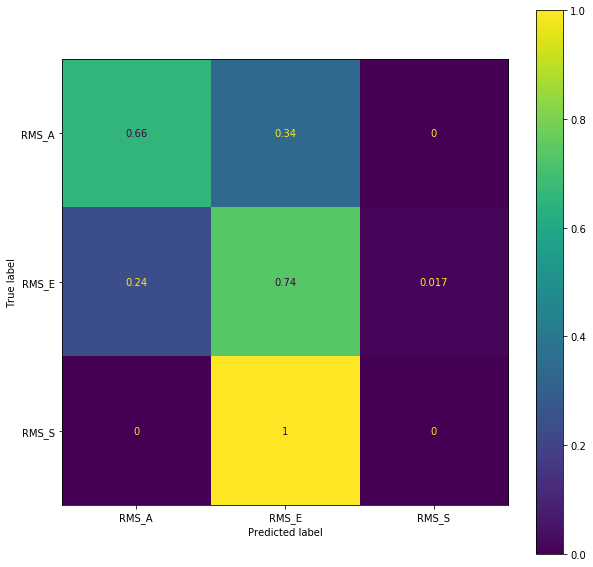

In [66]:
fig, ax = plt.subplots(1,1, figsize = (10,10))
ConfusionMatrixDisplay.from_predictions(results_summary['label'], results_summary['prediction'], normalize='true', ax = ax)

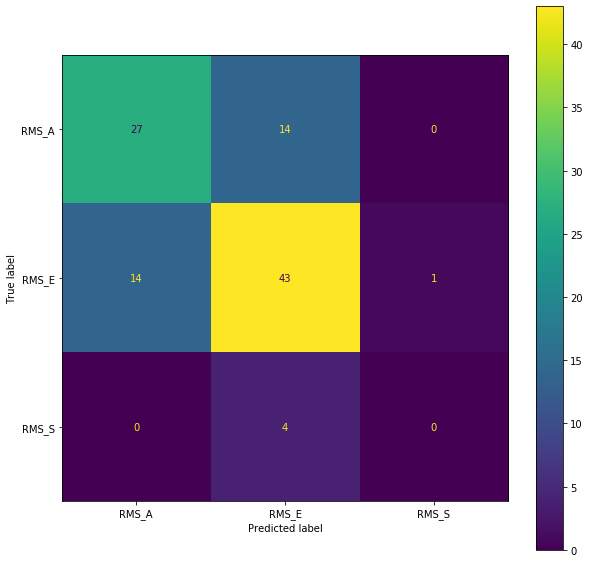

In [67]:
fig, ax = plt.subplots(1,1, figsize = (10,10))
ConfusionMatrixDisplay.from_predictions(results_summary['label'], results_summary['prediction'], ax = ax)

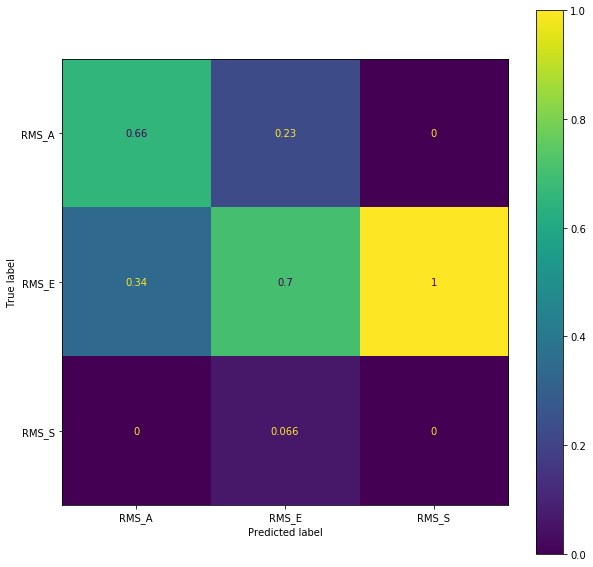

In [68]:
fig, ax = plt.subplots(1,1, figsize = (10,10))
ConfusionMatrixDisplay.from_predictions(results_summary['label'], results_summary['prediction'], normalize = 'pred', ax = ax)

In [69]:
f1_score(results_summary['label'], results_summary['prediction'], average = 'macro')

0.46040855366536865

In [70]:
recall_score(results_summary['label'], results_summary['prediction'], average = 'macro')

0.4666386319035604

In [71]:
precision_score(results_summary['label'], results_summary['prediction'], average = 'macro')

0.45448487271757965

In [72]:
accuracy_score(results_summary['label'], results_summary['prediction'])

0.6796116504854369

In [73]:
results_summary['label'].value_counts()/101

RMS_E    0.574257
RMS_A    0.405941
RMS_S    0.039604
Name: label, dtype: float64